In [ ]:
from ucimlrepo import fetch_ucirepo
import polars as pl
from loguru import logger
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import arviz as az

## Understanding the [dataset](https://archive.ics.uci.edu/dataset/45/heart+disease):
- `cp` = Chest pain type
- `trestbps` = resting blood pressure (mm Hg) on admission to hospital
- `chol` = serum cholestrol in mg/dl
- `fbs` = A binary indicator where 1 = the fasting bloog sugar was greater than 120 mg/dl, 0 otherwise
- `restecg` = resting electrocardiography results
- `thalach` = maximum heart rate achieved
- `exang` = whether angina was exercise-induced (1 = yes; 0 = no)
- `oldpeak` = ST depression induced by exercise relative to rest
- `slope` = slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 = downsloping)
- `ca` = number of major vessels (0 - 3) colored by fluoroscopy
- `thal` = 3 = normal; 6 = fixed defect; 7 = reversable defect
- `num` = diagnosis of heart disease (angiographic disease status; 0 = no presence, scale of 0 to 4)

In [56]:
try:
    dataset = pl.read_csv("dataset.csv")
except Exception as e:
    logger.error(e)
    dataset = fetch_ucirepo(id=45).data["original"]
    dataset = pl.DataFrame(dataset)

    dataset = dataset.with_columns(
        pl.col("sex").replace_strict({0: "female", 1: "male"}),
        pl.col("cp").replace_strict(
            {
                1: "typical angina",
                2: "atypical angina",
                3: "non-anginal pain",
                4: "asymptomatic",
            }
        ),
        pl.col("fbs").replace_strict({1: "yes", 0: "no"}),
        pl.col("restecg").replace_strict(
            {0: "normal", 1: "abnormal", 2: "hypertrophy"}
        ),
        pl.col("exang").replace_strict({1: "yes", 0: "no"}),
        pl.col("slope").replace_strict({1: "up", 2: "flat", 3: "down"}),
        pl.col("thal").replace_strict(
            {3: "normal", 6: "fixed defect", 7: "reversable defect"}
        ),
        pl.col("num").replace_strict({0: "no", 1: "yes", 2: "yes", 3: "yes", 4: "yes"}),
    ).with_columns(
        pl.col("sex").cast(pl.Enum(["male", "female"])),
        pl.col("cp").cast(
            pl.Enum(
                [
                    "typical angina",
                    "atypical angina",
                    "non-anginal pain",
                    "asymptomatic",
                ]
            )
        ),
        pl.col("fbs").cast(pl.Enum(["no", "yes"])),
        pl.col("restecg").cast(pl.Enum(["normal", "abnormal", "hypertrophy"])),
        pl.col("exang").cast(pl.Enum(["no", "yes"])),
        pl.col("slope").cast(pl.Enum(["down", "flat", "up"])),
        pl.col("thal").cast(pl.Enum(["normal", "fixed defect", "reversable defect"])),
        pl.col("num").cast(pl.Enum(["no", "yes"])),
    )

    dataset.write_csv("dataset.csv")

dataset

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
i64,str,str,i64,i64,str,str,i64,str,f64,str,f64,str,str
63,"""male""","""typical angina""",145,233,"""yes""","""hypertrophy""",150,"""no""",2.3,"""down""",0.0,"""fixed defect""","""no"""
67,"""male""","""asymptomatic""",160,286,"""no""","""hypertrophy""",108,"""yes""",1.5,"""flat""",3.0,"""normal""","""yes"""
67,"""male""","""asymptomatic""",120,229,"""no""","""hypertrophy""",129,"""yes""",2.6,"""flat""",2.0,"""reversable defect""","""yes"""
37,"""male""","""non-anginal pain""",130,250,"""no""","""normal""",187,"""no""",3.5,"""down""",0.0,"""normal""","""no"""
41,"""female""","""atypical angina""",130,204,"""no""","""hypertrophy""",172,"""no""",1.4,"""up""",0.0,"""normal""","""no"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…
45,"""male""","""typical angina""",110,264,"""no""","""normal""",132,"""no""",1.2,"""flat""",0.0,"""reversable defect""","""yes"""
68,"""male""","""asymptomatic""",144,193,"""yes""","""normal""",141,"""no""",3.4,"""flat""",2.0,"""reversable defect""","""yes"""
57,"""male""","""asymptomatic""",130,131,"""no""","""normal""",115,"""yes""",1.2,"""flat""",1.0,"""reversable defect""","""yes"""


In [57]:
dataset.null_count()

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,4,2,0


In [ ]:
dataset = dataset.drop_nulls()
dataset: pd.DataFrame = dataset.to_pandas().rename(columns={"num": "has_hd"})

dataset

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,has_hd
0,63,male,typical angina,145,233,yes,hypertrophy,150,no,2.3,down,0.0,fixed defect,no
1,67,male,asymptomatic,160,286,no,hypertrophy,108,yes,1.5,flat,3.0,normal,yes
2,67,male,asymptomatic,120,229,no,hypertrophy,129,yes,2.6,flat,2.0,reversable defect,yes
3,37,male,non-anginal pain,130,250,no,normal,187,no,3.5,down,0.0,normal,no
4,41,female,atypical angina,130,204,no,hypertrophy,172,no,1.4,up,0.0,normal,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,57,female,asymptomatic,140,241,no,normal,123,yes,0.2,flat,0.0,reversable defect,yes
293,45,male,typical angina,110,264,no,normal,132,no,1.2,flat,0.0,reversable defect,yes
294,68,male,asymptomatic,144,193,yes,normal,141,no,3.4,flat,2.0,reversable defect,yes
295,57,male,asymptomatic,130,131,no,normal,115,yes,1.2,flat,1.0,reversable defect,yes


In [59]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    int64  
 1   sex       297 non-null    object 
 2   cp        297 non-null    object 
 3   trestbps  297 non-null    int64  
 4   chol      297 non-null    int64  
 5   fbs       297 non-null    object 
 6   restecg   297 non-null    object 
 7   thalach   297 non-null    int64  
 8   exang     297 non-null    object 
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    object 
 11  ca        297 non-null    float64
 12  thal      297 non-null    object 
 13  has_hd    297 non-null    object 
dtypes: float64(2), int64(4), object(8)
memory usage: 32.6+ KB


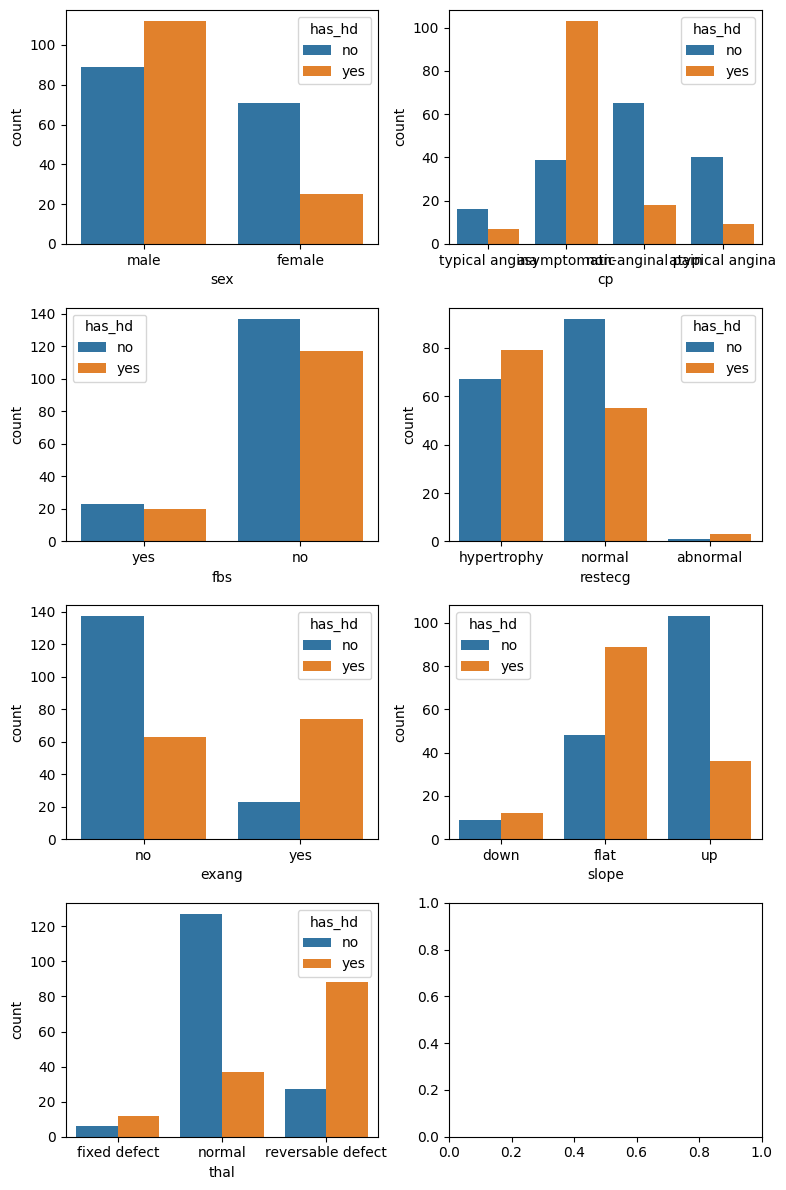

In [ ]:
features = {
    "sex": "bar",
    "cp": "bar",
    "fbs": "bar",
    "restecg": "bar",
    "exang": "bar",
    "slope": "bar",
    "thal": "bar",
}

_, axes = plt.subplots(4, 2, figsize=(8, 12))

for (column, plot_type), ax in zip(features.items(), axes.flatten()):
    sns.countplot(data=dataset, x=column, hue="has_hd", hue_order=["no", "yes"], ax=ax)

plt.tight_layout()
plt.show()

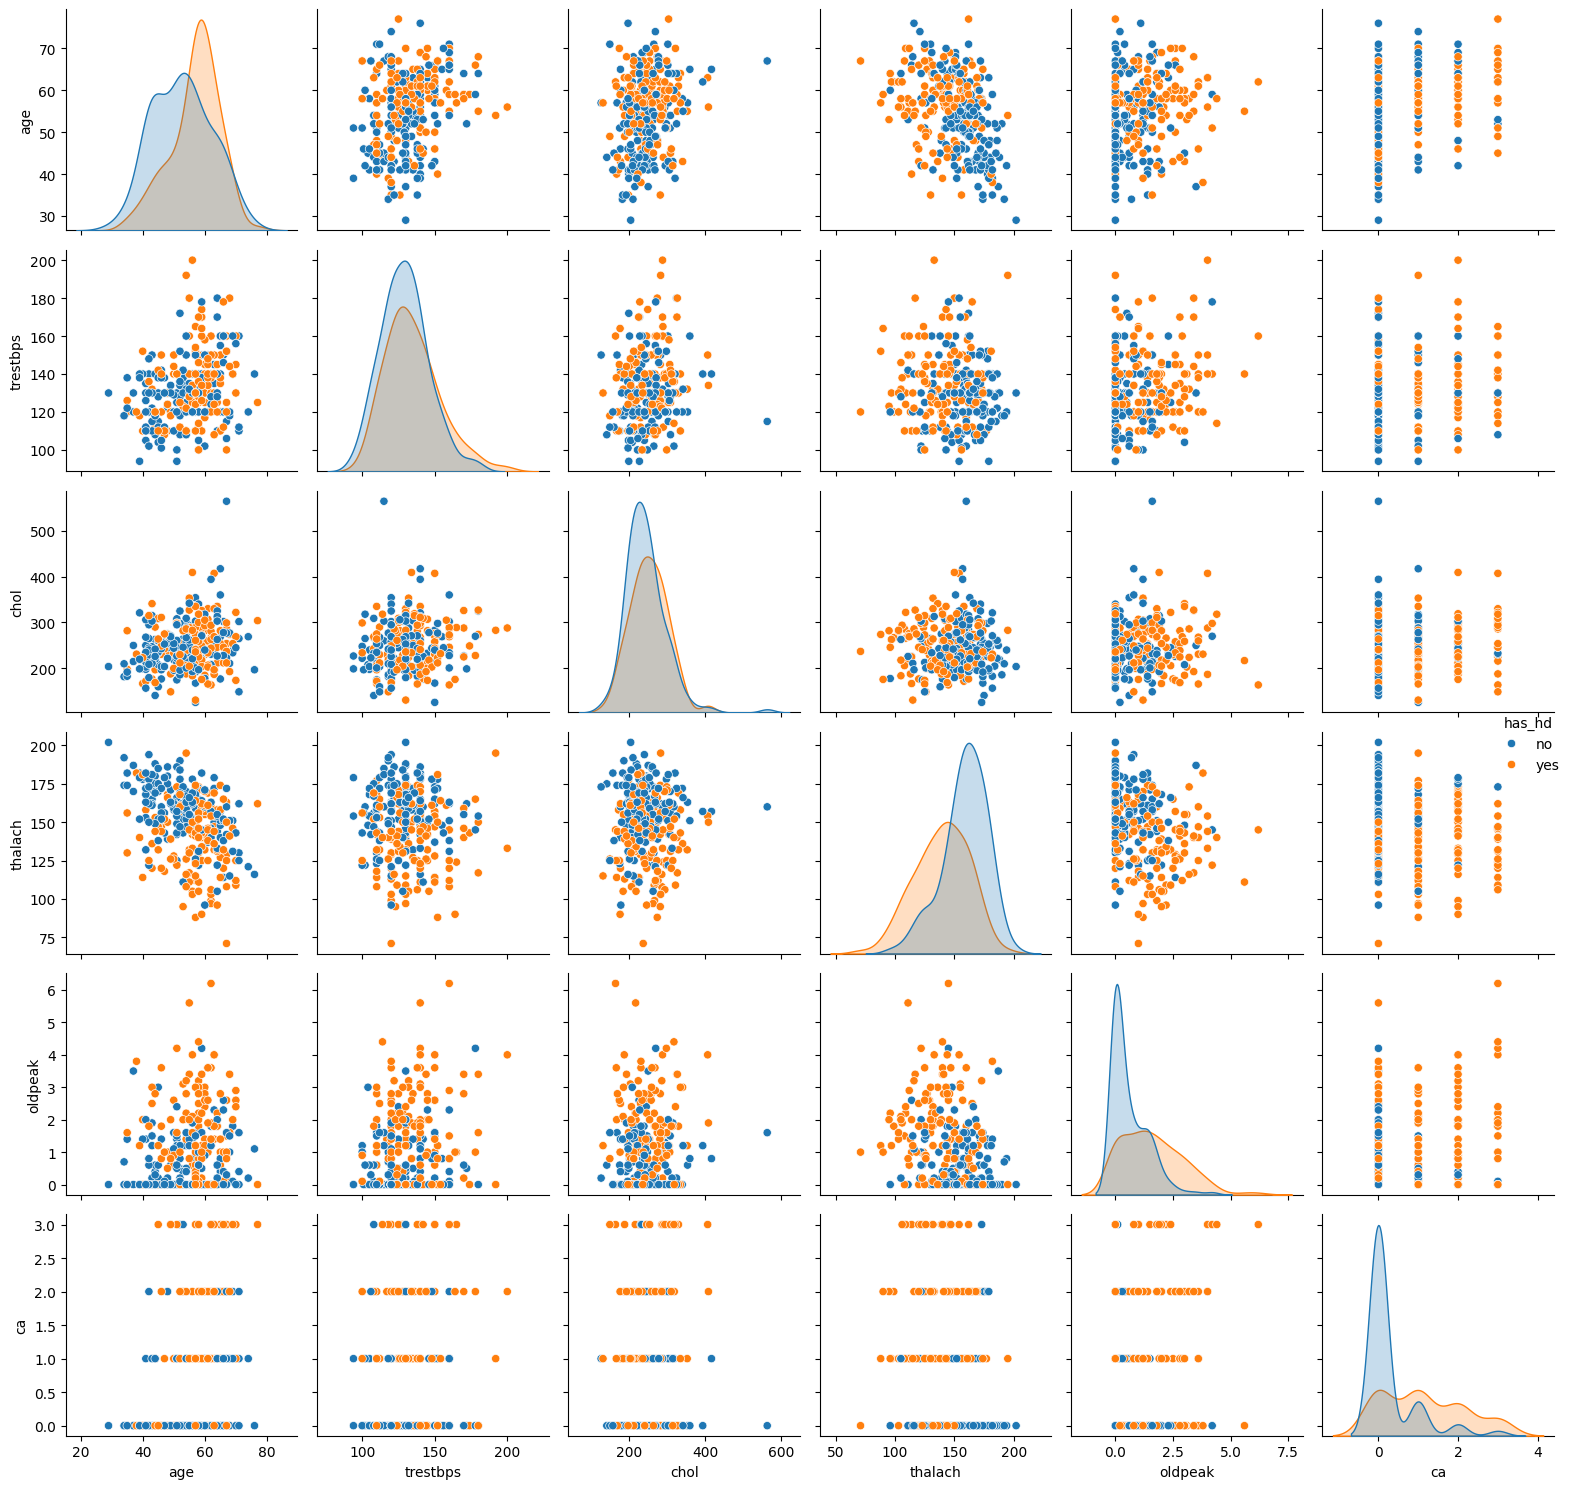

In [62]:
sns.pairplot(data=dataset, hue="has_hd", hue_order=["no", "yes"])
plt.tight_layout()
plt.show()

In [ ]:
sex_codes, sex_labels = pd.factorize(dataset["sex"])
cp_codes, cp_labels = pd.factorize(dataset["cp"])
fbs_codes, fbs_labels = pd.factorize(dataset["fbs"])
restecg_codes, restecg_labels = pd.factorize(dataset["restecg"])
exang_codes, exang_labels = pd.factorize(dataset["exang"])
slope_codes, slope_labels = pd.factorize(dataset["slope"])
thal_codes, thal_labels = pd.factorize(dataset["thal"])
hd_codes, hd_labels = pd.factorize(dataset["has_hd"])

In [143]:
coords = {
    "sex": sex_labels,
    "cp": cp_labels,
    "fbs": fbs_labels,
    "restecg": restecg_labels,
    "exang": exang_labels,
    "slope": slope_labels,
    "thal": thal_labels,
    "params": ["logit", "age"],
}

with pm.Model(coords=coords) as model1:
    target = pm.Data("target", hd_codes)

    # mu = pm.Normal("mu", 0, 10, dims="sex")
    # pm.Deterministic("p", pm.math.invlogit(mu))
    # pm.Bernoulli("likelihood", logit_p=mu[sex_codes], observed=target)

    # mu = pm.Normal('mu', 0, 10)
    # pm.Deterministic('p', pm.math.invlogit(mu))
    # pm.Bernoulli('likelihood', logit_p=mu, observed=target)

    parameters = pm.Normal("parameters", 0, 10, dims="params")
    pm.Deterministic("p", pm.math.invlogit(parameters[0]))
    pm.Bernoulli("likelihood", logit_p=parameters[0], observed=target)
    pm.HalfNormal("age", parameters[1], observed=dataset["age"])

    trace1 = pm.sample(2000, tune=1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [parameters]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [144]:
az.summary(trace1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
parameters[logit],-0.155,0.118,-0.377,0.064,0.001,0.001,8501.0,6082.0,1.0
parameters[age],53.041,1.998,49.309,56.841,0.022,0.023,8710.0,5917.0,1.0
p,0.461,0.029,0.407,0.516,0.000,0.000,8501.0,6082.0,1.0


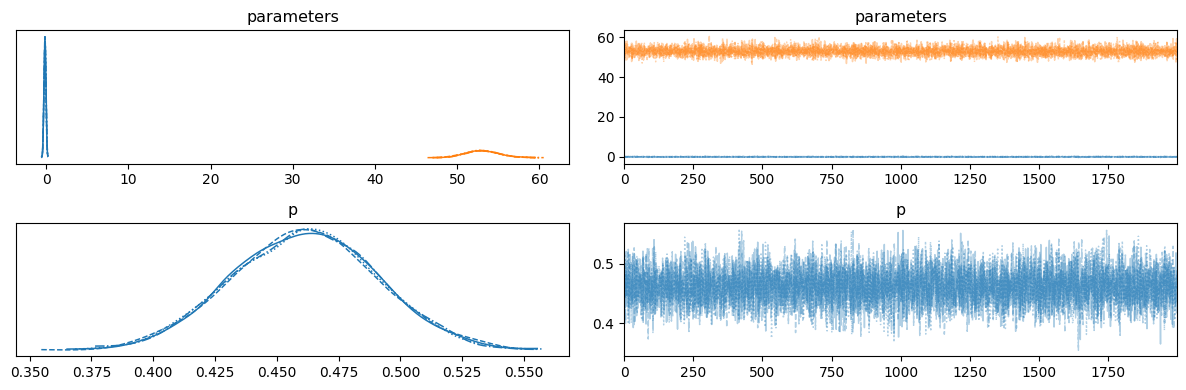

In [145]:
az.plot_trace(trace1)
plt.tight_layout()
plt.show()

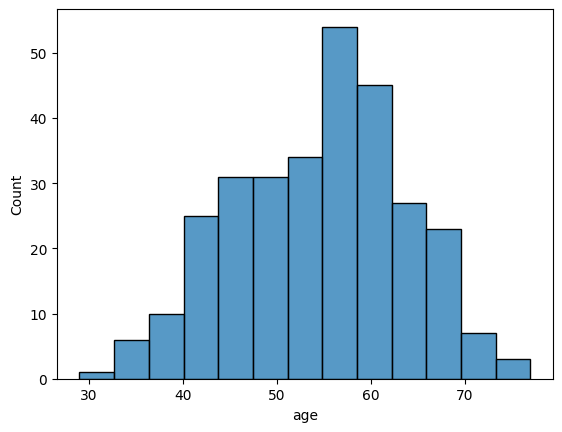

In [146]:
sns.histplot(data=dataset, x="age")
plt.show()